In [1]:
from pytubefix import YouTube
import pyaudio
import wave
import sys
import os
from raw_data.raw_data import *
from raw_data.constants import *
import crepe
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import sounddevice as sd
import struct

In [ ]:
sd.query_devices()

In [27]:
44100/1024 * 4

172.265625

In [7]:
FORMAT = pyaudio.paInt16                # We use 16bit format per sample
CHANNELS = 1
RATE = 44100
CHUNK = 1024                            # 1024bytes of data red from a buffer
RECORD_SECONDS = 3
# WAVE_OUTPUT_FILENAME = "file.wav"

audio = pyaudio.PyAudio()

# start Recording
stream = audio.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE, input=True,
                    frames_per_buffer=CHUNK)

frames = []
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)
frames = b''.join(frames).decode()

stream.stop_stream()
stream.close()
audio.terminate()

TypeError: sequence item 0: expected str instance, bytes found

In [31]:
chunk = 1024 
sample_format = pyaudio.paInt16  
chanels = 1
sr = 44100 
seconds = 4

In [32]:
pa = pyaudio.PyAudio()  

stream = pa.open(format=sample_format, channels=chanels, 
                 rate=sr, input=True, 
                 frames_per_buffer=chunk)
 
print('Recording...')
# Initialize array that be used for storing frames
frames = []  
 
# Store data in chunks for 8 seconds
for i in range(0, int(sr / chunk * seconds)):
    data = stream.read(chunk)
    frames.append(data)
frames = b''.join(frames)
# Stop and close the stream 
stream.stop_stream()
stream.close()
 
# Terminate - PortAudio interface
pa.terminate()

Recording...


In [33]:
len(frames)

352256

In [34]:
amplitude = np.frombuffer(frames, np.int16)

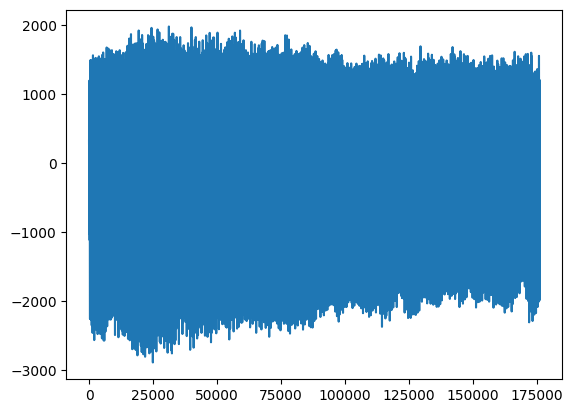

In [35]:
plt.plot(amplitude)

In [36]:
amplitude[-300000:]

array([323, 318, 304, ..., 730, 721, 703], dtype=int16)

In [37]:
time, frequency, confidence, activation = crepe.predict(amplitude, 44100, viterbi=True)

13/13 [==============================] - 0s 39ms/step


In [58]:
def freq_to_note(freq):
    notes = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']

    note_number = 12 * np.log2(freq / 440) + 49  
    note_number = round(note_number)
        
    note = (note_number - 1 ) % len(notes)
    note = notes[note]
    
    octave = (note_number + 8 ) // len(notes)
    
    return f"{note}_{octave}"

In [62]:
freq_to_note(141)

'C#_3'

(100.0, 140.0)

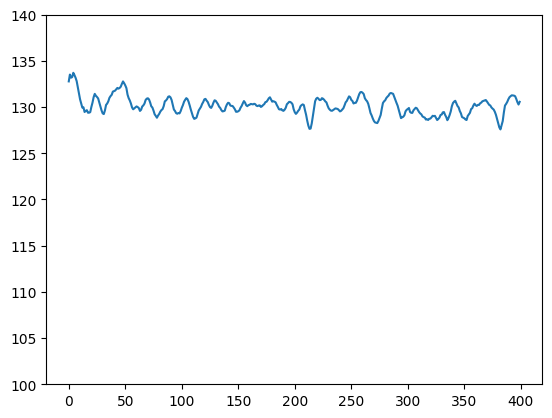

In [40]:
plt.plot(frequency)
plt.ylim(100,140)

In [16]:
audio_folder = "raw_data/raw_audio"
voices_folder = "raw_data/voices"

In [17]:
song_folder_url = "White_Copper_Alley___Lass_of_London_City_-_Ménestrel"
song_voice_url = "vocals.wav"

In [18]:
song = os.path.join(voices_folder, song_folder_url, song_voice_url)

In [19]:
sr, audio = wavfile.read(song)

In [ ]:
audio[350_000:350_050]

In [7]:
time, frequency, confidence, activation = crepe.predict(audio, sr, viterbi=True)

532/532 [==============================] - 12s 20ms/step


In [8]:
len(time)

17023

In [9]:
len(frequency)

17023

In [10]:
len(confidence)

17023

In [11]:
len(activation)

17023

In [12]:
time_split = time[2000:3000]
freq_split = frequency[2000:3000]

In [13]:
len(freq_split)

1000

In [14]:
# Essentia is needed but only works in Linux
# ALthough it seems crepe is fine, maybe we'll never know
# [x if x<550 and x>180 else None for x in freq_split]

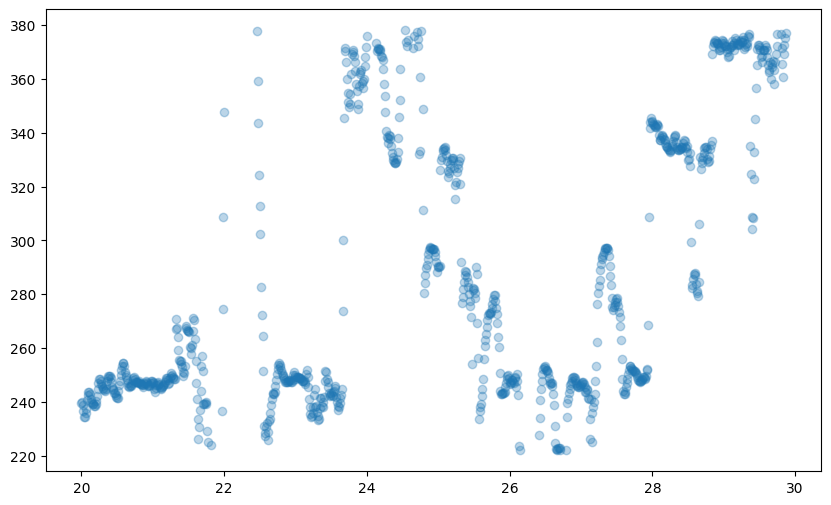

In [20]:
plt.figure(figsize=(10,6))
mean = np.mean(freq_split)
std = np.std(freq_split)
plt.scatter(time_split,[x if x<(mean+std) and x>(mean-std) else None for x in freq_split], alpha = 0.3)

In [27]:
np.std(freq_split)

209.50106670972906

In [35]:
len(time)

17023

In [36]:
len(frequency)

17023

In [5]:
from spleeter.separator import Separator

In [ ]:
separator = Separator(f"spleeter:2stems")
separator.separate_to_file(song,
                        "raw_data/voices",
                        duration = 540,
                        codec='wav',
                        filename_format='{filename}/{instrument}.{codec}')

In [11]:
one = videos_waiting_for_extract()[0]

In [12]:
one

'raw_data/raw_video/Che_si_può_fare_-_Barbara_Strozzi_(1619–1677)_-_Ménestrel/Che si può fare - Barbara Strozzi (1619–1677) - Ménestrel.m4a'

In [6]:
import os
import ffmpeg
import string

In [5]:
# Sona_Is_A_Chill_Mom__Conan_O'Brien_Needs_A_Friend.m4a

SyntaxError: unterminated string literal (detected at line 1) (3270841329.py, line 1)

In [7]:
one

"raw_data/raw_audio/Sona_Is_A_Chill_Mom__Conan_O'Brien_Needs_A_Friend/Sona Is A Chill Mom  Conan O'Brien Needs A Friend.m4a"

In [9]:
wf = wave.open(one)

Error: file does not start with RIFF id

In [8]:
for song in songs:
    print(videos_dir + "/" + song)

raw_data/raw_audio/Sona_Is_A_Chill_Mom__Conan_O'Brien_Needs_A_Friend


In [4]:
separate_voice(audio_file, stems = 2)

'POPO WORKS'

In [8]:
os.getcwd()

'C:\\Users\\chompu\\Desktop\\audio_windows\\sound_study\\marin_method'

In [6]:
import os
import ffmpeg
import string

In [ ]:

VIDEOS_URL = 'videos_from_yt'
AUDIOS_URL = 'audios_from_yt'

def convert_video_to_audio(title, encoder):
    stream = ffmpeg.input(f"{VIDEOS_URL}/{title}")
    stream = ffmpeg.output(stream, f"{AUDIOS_URL}/{title}.{encoder}")
    ffmpeg.run(stream)
    os.remove(os.path.join(VIDEOS_URL,title))

In [ ]:
def callback(input_data, frame_count, time_info, flags):
    ...

    return input_data, pyaudio.paContinue

stream = audio.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    stream_callback=callback,
                    frames_per_buffer=CHUNK)

In [ ]:
ys.__dict__

In [ ]:
ys.download()

In [5]:
pip install pytubefix

Note: you may need to restart the kernel to use updated packages.


In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import time
import pandas as pd
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [2]:
from webdriver_manager.chrome import ChromeDriverManager

In [3]:
options = webdriver.ChromeOptions()
options.add_experimental_option("detach", True)
options.add_argument("--disable-extensions")
options.add_argument("--disable-notifications")
options.add_argument("--disable-Advertisement")
options.add_argument("--disable-popup-blocking")
options.add_argument("start-maximized")
options.add_argument('headless')

In [4]:
service = Service(executable_path='chromedriver/chromedriver.exe')
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=service, options=options)
# ... Automate something here


In [12]:
driver.get('https://www.youtube.com/wendoverproductions/videos')
time.sleep(3)

item = []
SCROLL_PAUSE_TIME = 1
last_height = driver.execute_script("return document.documentElement.scrollHeight")

InvalidSessionIdException: Message: invalid session id: session deleted as the browser has closed the connection
from disconnected: not connected to DevTools
  (Session info: chrome=133.0.6943.53)
Stacktrace:
	GetHandleVerifier [0x00007FF6BCDF2EC5+28789]
	(No symbol) [0x00007FF6BCD5F870]
	(No symbol) [0x00007FF6BCBF8F9A]
	(No symbol) [0x00007FF6BCBE4DA5]
	(No symbol) [0x00007FF6BCC0971A]
	(No symbol) [0x00007FF6BCC7EFAF]
	(No symbol) [0x00007FF6BCC9EFB2]
	(No symbol) [0x00007FF6BCC76FF3]
	(No symbol) [0x00007FF6BCC3FF0E]
	(No symbol) [0x00007FF6BCC41193]
	GetHandleVerifier [0x00007FF6BD13D5FD+3479469]
	GetHandleVerifier [0x00007FF6BD1571A3+3584851]
	GetHandleVerifier [0x00007FF6BD14C44D+3540477]
	GetHandleVerifier [0x00007FF6BCEB8B6A+838938]
	(No symbol) [0x00007FF6BCD6A4EF]
	(No symbol) [0x00007FF6BCD66954]
	(No symbol) [0x00007FF6BCD66AF6]
	(No symbol) [0x00007FF6BCD56499]
	BaseThreadInitThunk [0x00007FFFEBF17374+20]
	RtlUserThreadStart [0x00007FFFEC99CC91+33]


In [8]:
item_count = 180

In [9]:
while item_count > len(item):
    driver.execute_script("window.scrollTo(0,document.documentElement.scrollHeight);")
    time.sleep(SCROLL_PAUSE_TIME)
    new_height = driver.execute_script("return document.documentElement.scrollHeight")

    if new_height == last_height:
        break
    last_height = new_height

In [10]:
data = []
try:
    for e in WebDriverWait(driver, 20).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'div#details'))):
        title = e.find_element(By.CSS_SELECTOR,'a#video-title-link').get_attribute('title')
        vurl = e.find_element(By.CSS_SELECTOR,'a#video-title-link').get_attribute('href')
        views= e.find_element(By.XPATH,'.//*[@id="metadata"]//span[@class="inline-metadata-item style-scope ytd-video-meta-block"][1]').text
        date_time = e.find_element(By.XPATH,'.//*[@id="metadata"]//span[@class="inline-metadata-item style-scope ytd-video-meta-block"][2]').text
        data.append({
            'video_url':vurl,
            'title':title,
            'date_time':date_time,
            'views':views
            })
except:
    pass
    
item = data
print(item)
print(len(item))

[{'video_url': 'https://www.youtube.com/watch?v=CxfFKuSfQ8c', 'title': 'How F1 Exploded', 'date_time': '1 day ago', 'views': '422K views'}, {'video_url': 'https://www.youtube.com/watch?v=HuMxQzX0uso', 'title': 'The Logistics of Natural Gas', 'date_time': '9 days ago', 'views': '862K views'}, {'video_url': 'https://www.youtube.com/watch?v=74E-eAxQ9P4', 'title': "Volkswagen's China Problem", 'date_time': '2 weeks ago', 'views': '1.2M views'}, {'video_url': 'https://www.youtube.com/watch?v=FyemWfUZ2lo', 'title': 'The 20 Most Important Flights of 2024', 'date_time': '1 month ago', 'views': '693K views'}, {'video_url': 'https://www.youtube.com/watch?v=B2j-LgcA7Gk', 'title': 'The Battle Over NYC Congestion Pricing', 'date_time': '1 month ago', 'views': '1.2M views'}, {'video_url': 'https://www.youtube.com/watch?v=RckX1yiVPIE', 'title': 'How Arenas Transform Overnight', 'date_time': '2 months ago', 'views': '1.8M views'}, {'video_url': 'https://www.youtube.com/watch?v=cQI9z7picQI', 'title': "